In [2]:
# ============================================================
# 🧩 Cell 1 — Imports, Load Data, and Label Targets
# ============================================================

import os
import json
import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ============================================================
# CONFIG
# ============================================================
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"     # <-- change here if needed
TIMEFRAME = "4hour"         # try "1hour" or others
PRICE_MOVE_THRESHOLD = 0.002  # 0.2% up = BUY
LOOKBACK = 60

# ============================================================
# LOAD CSV
# ============================================================
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    if not os.path.exists(folder):
        raise FileNotFoundError(f"❌ Folder not found for {stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"❌ No CSV found for {stock_code} {tf}")
    latest_file = sorted(files)[-1]
    path = os.path.join(folder, latest_file)
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True)
    return df

# ============================================================
# LABELING
# ============================================================
def label_data(df: pd.DataFrame, threshold: float = 0.002):
    """Label BUY (1) vs NOACTION (0) based on % next candle move."""
    df = df.copy()
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna(subset=["target"]).reset_index(drop=True)

# ============================================================
# RUN LOAD + LABEL
# ============================================================
df = load_csv(STOCK_CODE, TIMEFRAME)
df_labeled = label_data(df, PRICE_MOVE_THRESHOLD)

print(f"\n✅ Loaded {len(df_labeled)} rows for {STOCK_CODE} [{TIMEFRAME}]")
print(f"Target distribution:\n{df_labeled['target'].value_counts(normalize=True)*100}\n")

# Preview
df_labeled.head(10)


📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_4hour_2024-11-03_to_2025-11-03.csv

✅ Loaded 287 rows for FORCEMOT [4hour]
Target distribution:
target
0    54.703833
1    45.296167
Name: proportion, dtype: float64



,Timestamp,Open,High,Low,Close,Volume,MA_Fast,MA_Slow,BB_Upper,BB_Lower,...,MACD_Signal,MACD_Hist,+DI,-DI,ADX,RSI14,ATR14,atr_pct,ret,target
0,2025-04-04 12:00:00,8934.50,8958.55,8863.40,8863.40,124,8863.4000,8863.4000,8863.4000,8863.4000,...,0.0000,0.0000,0.0000,0.0000,NaN,NaN,95.1500,1.0735,0.010605,1
1,2025-04-04 16:00:00,8863.40,8957.40,8805.00,8957.40,1096,8910.4000,8910.4000,9004.4000,8816.4000,...,1.4997,5.9989,0.0000,4.2034,100.0000,NaN,99.2393,1.1079,-0.089730,0
2,2025-04-07 12:00:00,8116.00,8411.30,7860.00,8153.65,10038,8658.1500,8658.1500,9375.7370,7940.5630,...,-8.9660,-41.8628,0.0000,41.8523,100.0000,NaN,170.5365,2.0915,0.020402,1
3,2025-04-07 16:00:00,8153.65,8384.05,8099.80,8320.00,2744,8573.6125,8573.6125,9260.6041,7886.6209,...,-23.7083,-58.9692,0.0000,37.0960,100.0000,NaN,178.6589,2.1473,0.015625,1
4,2025-04-08 12:00:00,8500.00,8589.85,8310.00,8450.00,3452,8548.8900,8548.8900,9171.2606,7926.5194,...,-38.2301,-58.0874,7.9080,33.1069,97.2456,NaN,185.8868,2.1998,0.001183,0
5,2025-04-08 16:00:00,8450.00,8511.20,8412.50,8460.00,906,8534.0750,8534.0750,9106.0692,7962.0808,...,-51.6059,-53.5030,7.5977,31.8078,94.6879,NaN,179.6592,2.1236,0.008056,1
6,2025-04-09 12:00:00,8460.00,8560.30,8364.15,8528.15,3719,8533.2286,8533.2286,9062.8085,8003.6486,...,-62.3572,-43.0052,8.9485,29.3434,91.7289,NaN,180.8371,2.1205,-0.002890,0
7,2025-04-09 16:00:00,8528.15,8595.90,8433.00,8503.50,2400,8529.5125,8529.5125,9025.2793,8033.7457,...,-71.1511,-35.1756,9.7848,27.4419,88.5648,NaN,179.5559,2.1116,0.027589,1
8,2025-04-11 12:00:00,8585.90,8851.00,8557.00,8738.10,1554,8552.6889,8552.6889,9038.1412,8067.2366,...,-74.3521,-12.8039,18.0294,23.8859,83.2368,NaN,191.5519,2.1921,-0.002867,0
9,2025-04-11 16:00:00,8738.10,8759.65,8662.00,8713.05,640,8535.9833,8568.7250,9039.2090,8098.2410,...,-74.1099,0.9687,17.3491,22.9846,78.2893,NaN,184.8446,2.1215,0.021456,1


📊 Class distribution:
target
0    157
1    130
Name: count, dtype: int64

% Distribution:
target
0    54.7
1    45.3
Name: count, dtype: float64


C:\temp\ipykernel_10032\3348930006.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


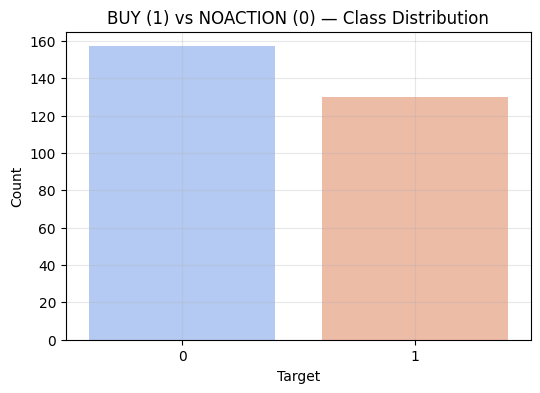

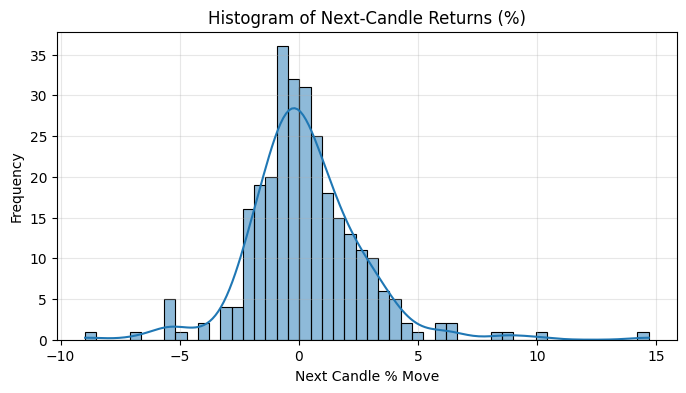


📈 Return Summary:
count    28600.000000
mean         0.285934
std          2.439364
min         -8.973028
1%          -5.566741
10%         -1.978634
50%          0.030940
90%          2.997147
99%          8.523828
max         14.684241
Name: ret, dtype: float64


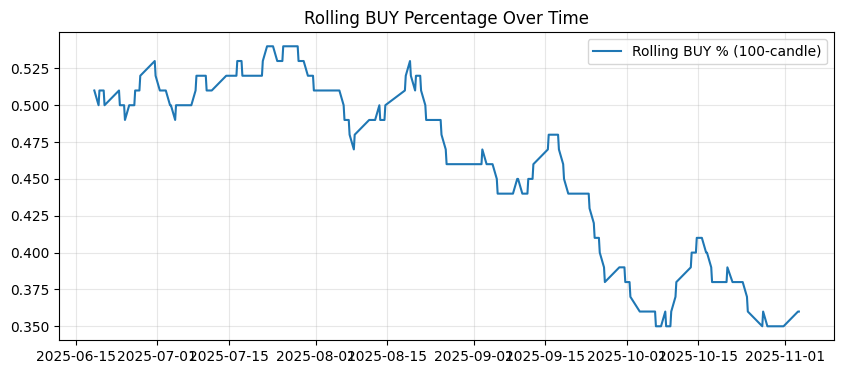

In [3]:
# ============================================================
# 🧩 Cell 2 — Target Distribution & Basic Return Stats
# ============================================================

print("📊 Class distribution:")
class_counts = df_labeled['target'].value_counts()
print(class_counts)
print("\n% Distribution:")
print(round(class_counts / len(df_labeled) * 100, 2))

# --- Plot class imbalance ---
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
plt.title("BUY (1) vs NOACTION (0) — Class Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

# --- Return statistics ---
plt.figure(figsize=(8,4))
sns.histplot(df_labeled['ret']*100, bins=50, kde=True)
plt.title("Histogram of Next-Candle Returns (%)")
plt.xlabel("Next Candle % Move")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

print("\n📈 Return Summary:")
print(df_labeled['ret'].describe(percentiles=[0.01,0.1,0.5,0.9,0.99])*100)

# BUY frequency over time
df_labeled["rolling_BUY"] = df_labeled["target"].rolling(100).mean()
plt.figure(figsize=(10,4))
plt.plot(df_labeled["Timestamp"], df_labeled["rolling_BUY"], label="Rolling BUY % (100-candle)")
plt.legend(); plt.title("Rolling BUY Percentage Over Time"); plt.grid(alpha=0.3)
plt.show()


🔍 Top correlations with BUY target:
target         1.000000
ret            0.698406
rolling_BUY    0.098421
RSI14          0.084617
+DI            0.043810
MACD_Hist      0.008190
MACD          -0.008721
MACD_Signal   -0.012003
ADX           -0.028112
Volume        -0.059640
-DI           -0.087076
BB_Lower      -0.097632
Close         -0.098979
Low           -0.099697
MA_Slow       -0.106873
Name: target, dtype: float64


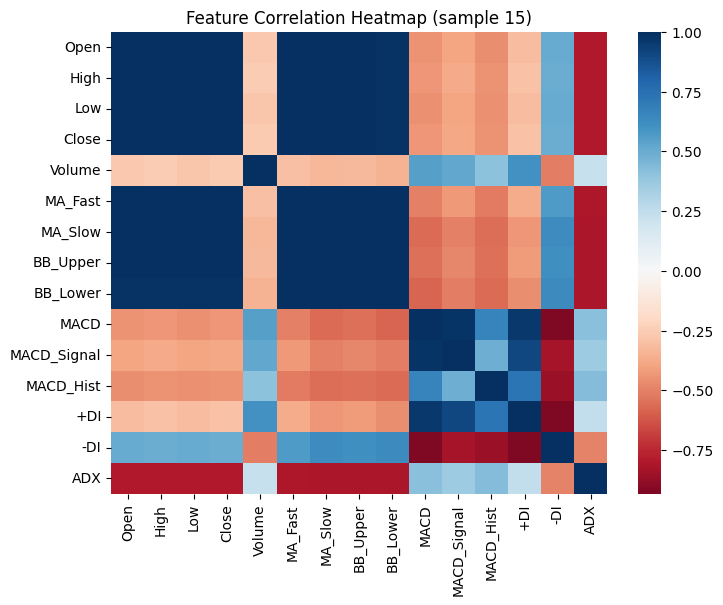

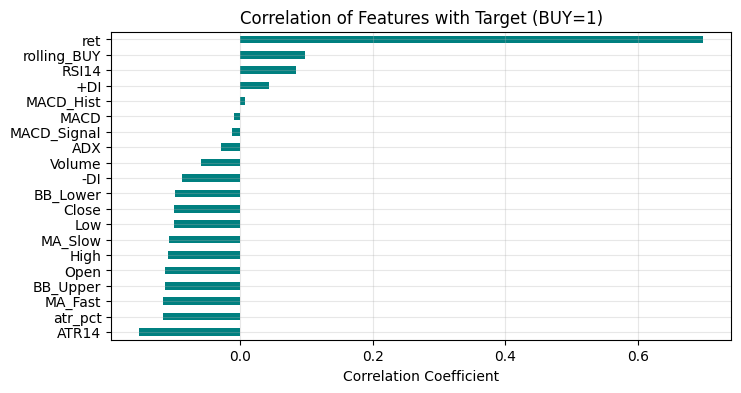

In [4]:
# ============================================================
# 🧩 Cell 3 — Feature Correlations with Target
# ============================================================

numeric_cols = df_labeled.select_dtypes(include=[np.number]).columns
corr = df_labeled[numeric_cols].corr()

# Correlation with target
corr_target = corr['target'].sort_values(ascending=False)
print("🔍 Top correlations with BUY target:")
print(corr_target.head(15))

# --- Plot correlation heatmap (top 15) ---
plt.figure(figsize=(8,6))
sns.heatmap(corr[numeric_cols].corr().iloc[:15, :15], cmap="RdBu", center=0)
plt.title("Feature Correlation Heatmap (sample 15)")
plt.show()

# --- Plot correlation with target ---
plt.figure(figsize=(8,4))
corr_target.drop("target").sort_values(ascending=True).plot(kind='barh', color='teal')
plt.title("Correlation of Features with Target (BUY=1)")
plt.xlabel("Correlation Coefficient")
plt.grid(alpha=0.3)
plt.show()


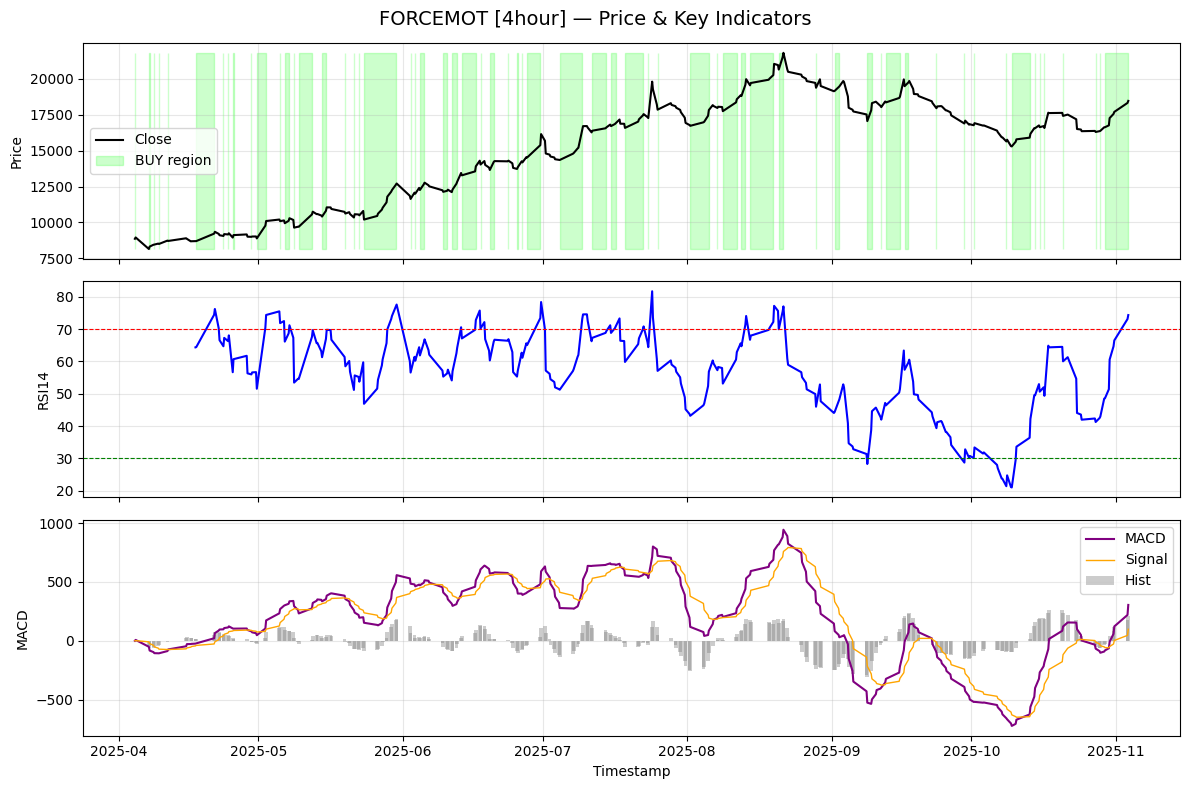


📉 Sample BUY windows:


,Timestamp,Close,RSI14,MACD,MACD_Signal
0,2025-04-04 12:00:00,8863.40,NaN,0.0000,0.0000
2,2025-04-07 12:00:00,8153.65,NaN,-50.8287,-8.9660
3,2025-04-07 16:00:00,8320.00,NaN,-82.6774,-23.7083
5,2025-04-08 16:00:00,8460.00,NaN,-105.1089,-51.6059
7,2025-04-09 16:00:00,8503.50,NaN,-106.3267,-71.1511
9,2025-04-11 16:00:00,8713.05,NaN,-73.1413,-74.1099
15,2025-04-17 16:00:00,8702.95,64.4435,-21.8666,-39.1318
16,2025-04-21 12:00:00,9221.00,74.4624,21.3477,-27.0359
20,2025-04-23 12:00:00,9060.95,64.7158,97.8233,41.6885
22,2025-04-24 12:00:00,9164.00,66.3004,113.3909,66.6932


In [5]:
# ============================================================
# 🧩 Cell 4 — Visual Indicator Trends
# ============================================================

# subset last 300 candles for clarity
plot_df = df_labeled.tail(300).copy()

fig, axes = plt.subplots(3, 1, figsize=(12,8), sharex=True)
fig.suptitle(f"{STOCK_CODE} [{TIMEFRAME}] — Price & Key Indicators", fontsize=14)

# --- Price with BUY regions ---
axes[0].plot(plot_df["Timestamp"], plot_df["Close"], label="Close", color="black")
axes[0].fill_between(plot_df["Timestamp"], plot_df["Close"].min(),
                     plot_df["Close"].max(), where=plot_df["target"]==1,
                     color="lime", alpha=0.2, label="BUY region")
axes[0].set_ylabel("Price")
axes[0].legend(); axes[0].grid(alpha=0.3)

# --- RSI Plot ---
axes[1].plot(plot_df["Timestamp"], plot_df["RSI14"], label="RSI14", color="blue")
axes[1].axhline(70, color="red", ls="--", lw=0.8)
axes[1].axhline(30, color="green", ls="--", lw=0.8)
axes[1].set_ylabel("RSI14")
axes[1].grid(alpha=0.3)

# --- MACD Plot ---
axes[2].plot(plot_df["Timestamp"], plot_df["MACD"], label="MACD", color="purple")
axes[2].plot(plot_df["Timestamp"], plot_df["MACD_Signal"], label="Signal", color="orange", lw=1)
axes[2].bar(plot_df["Timestamp"], plot_df["MACD_Hist"], label="Hist", color="grey", alpha=0.4)
axes[2].legend(); axes[2].grid(alpha=0.3)
axes[2].set_ylabel("MACD")
axes[2].set_xlabel("Timestamp")

plt.tight_layout()
plt.show()

# --- Additional summary ---
print("\n📉 Sample BUY windows:")
display(plot_df.loc[plot_df['target']==1, ["Timestamp","Close","RSI14","MACD","MACD_Signal"]].head(10))


✅ Retained 17 valid indicator features.

📊 Class Distribution (%):
target
0    54.7
1    45.3
Name: proportion, dtype: float64

📈 Data Snapshot:


C:\temp\ipykernel_10032\3652968650.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_proc.fillna(method="ffill", inplace=True)
C:\temp\ipykernel_10032\3652968650.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_proc.fillna(method="bfill", inplace=True)
C:\temp\ipykernel_10032\3652968650.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")
C:\temp\ipykernel_10032\3652968650.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")


,Timestamp,target,Open,High,Low,Close,Volume
0,2025-04-04 12:00:00,1,-1.662671,-1.705252,-1.653075,-1.697739,-0.858986
1,2025-04-04 16:00:00,0,-1.682068,-1.705563,-1.669359,-1.671867,-0.716420
2,2025-04-07 12:00:00,1,-1.885967,-1.853160,-1.932869,-1.893087,0.595123
3,2025-04-07 16:00:00,1,-1.875696,-1.860525,-1.866002,-1.847301,-0.474704
4,2025-04-08 12:00:00,0,-1.781208,-1.804903,-1.807388,-1.811521,-0.370860



📘 Top 15 correlations with BUY target:
target         1.000000
RSI14          0.080505
+DI            0.043810
MACD_Hist      0.008190
MACD          -0.008721
ADX           -0.010952
MACD_Signal   -0.012003
Volume        -0.059640
-DI           -0.087076
BB_Lower      -0.097632
Close         -0.098979
Low           -0.099697
MA_Slow       -0.106873
High          -0.109218
Open          -0.112786
Name: target, dtype: float64


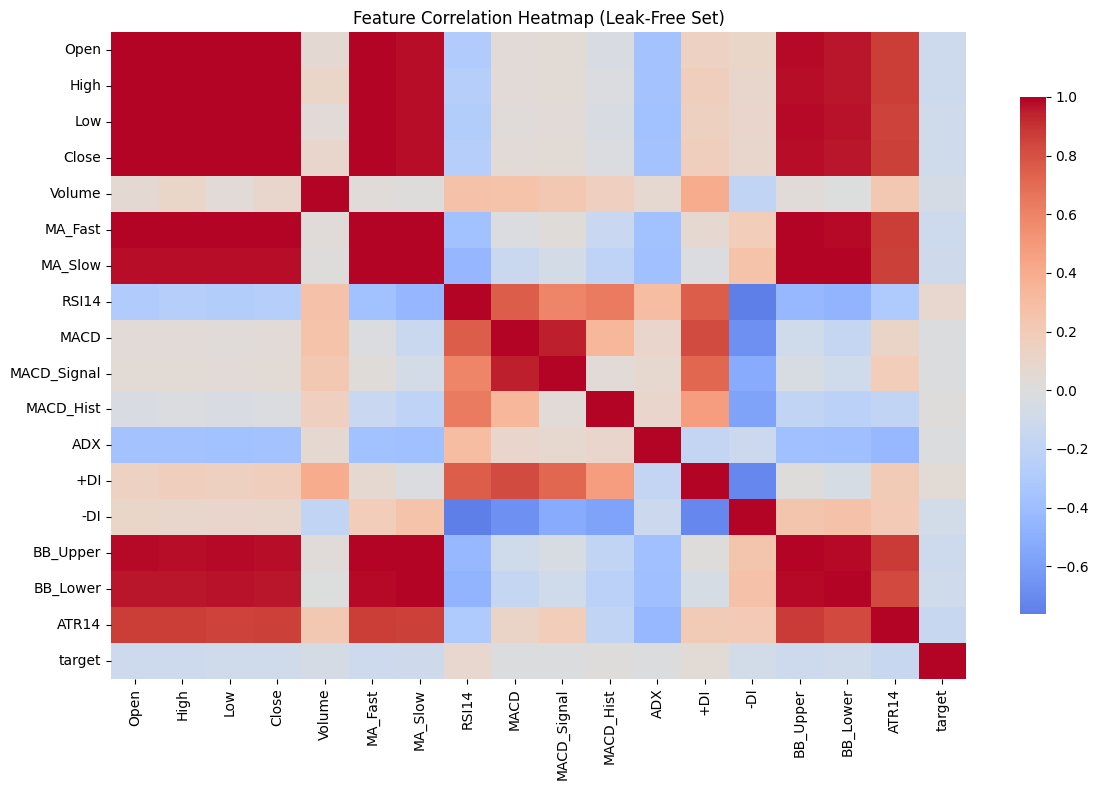


⚠️ Highly correlated feature pairs (>|0.9|):
  Open            ↔ High            → corr=0.997
  Open            ↔ Low             → corr=0.997
  Open            ↔ Close           → corr=0.995
  Open            ↔ MA_Fast         → corr=0.991
  Open            ↔ MA_Slow         → corr=0.977
  Open            ↔ BB_Upper        → corr=0.981
  Open            ↔ BB_Lower        → corr=0.965
  High            ↔ Open            → corr=0.997
  High            ↔ Low             → corr=0.996
  High            ↔ Close           → corr=0.998
  High            ↔ MA_Fast         → corr=0.988
  High            ↔ MA_Slow         → corr=0.974
  High            ↔ BB_Upper        → corr=0.978
  High            ↔ BB_Lower        → corr=0.962
  Low             ↔ Open            → corr=0.997
  Low             ↔ High            → corr=0.996
  Low             ↔ Close           → corr=0.997
  Low             ↔ MA_Fast         → corr=0.990
  Low             ↔ MA_Slow         → corr=0.978
  Low             ↔ BB_

In [19]:
# ============================================================
# 🧩 Cell 5 — Clean, Leak-Free Preprocessing (for all TF models)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 1️⃣ Base Cleaning
# ------------------------------------------------------------
df_proc = df_labeled.copy()

# Remove any known future-dependent features
for col in ["ret", "rolling_BUY"]:
    if col in df_proc.columns:
        df_proc.drop(columns=[col], inplace=True)

# Handle infs and NaNs
df_proc.replace([np.inf, -np.inf], np.nan, inplace=True)
df_proc.fillna(method="ffill", inplace=True)
df_proc.fillna(method="bfill", inplace=True)

# ------------------------------------------------------------
# 2️⃣ Feature Selection — keep only causal indicators
# ------------------------------------------------------------
FEATURE_COLS = [
    "Open", "High", "Low", "Close", "Volume",
    "MA_Fast", "MA_Slow",
    "RSI14", "MACD", "MACD_Signal", "MACD_Hist",
    "ADX", "+DI", "-DI",
    "BB_Upper", "BB_Lower", "ATR14"
]

# Keep only those actually present in data
FEATURE_COLS = [c for c in FEATURE_COLS if c in df_proc.columns]

print(f"✅ Retained {len(FEATURE_COLS)} valid indicator features.")

# ------------------------------------------------------------
# 3️⃣ Fill and scale numeric features
# ------------------------------------------------------------
df_proc[FEATURE_COLS] = (
    df_proc[FEATURE_COLS]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(method="ffill")
    .fillna(method="bfill")
)

scaler = StandardScaler()
df_proc[FEATURE_COLS] = scaler.fit_transform(df_proc[FEATURE_COLS])

# ------------------------------------------------------------
# 4️⃣ Dataset Summary
# ------------------------------------------------------------
print("\n📊 Class Distribution (%):")
print(df_proc["target"].value_counts(normalize=True).mul(100).round(1))

print("\n📈 Data Snapshot:")
display(df_proc.head(5)[["Timestamp", "target"] + FEATURE_COLS[:5]])

# ------------------------------------------------------------
# 5️⃣ Correlation Analysis
# ------------------------------------------------------------
corr = df_proc[FEATURE_COLS + ["target"]].corr()

print("\n📘 Top 15 correlations with BUY target:")
print(corr["target"].sort_values(ascending=False).head(15))

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap (Leak-Free Set)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6️⃣ Check for Multicollinearity (> 0.9)
# ------------------------------------------------------------
threshold = 0.9
corr_pairs = corr.abs().unstack()
high_corr = [
    (a, b, corr_pairs[(a, b)]) for a, b in corr_pairs.index
    if a != b and corr_pairs[(a, b)] > threshold
]

if high_corr:
    print("\n⚠️ Highly correlated feature pairs (>|0.9|):")
    for a, b, v in high_corr:
        print(f"  {a:15s} ↔ {b:15s} → corr={v:.3f}")
else:
    print("\n✅ No highly correlated (>0.9) features detected.")

# ------------------------------------------------------------
# 7️⃣ Final dataset for modeling
# ------------------------------------------------------------
df_ready = df_proc[["Timestamp", "target"] + FEATURE_COLS].copy()
print("\n✅ Preprocessing complete — leak-free dataset ready for training!")


In [20]:
df_ready.head()

,Timestamp,target,Open,High,Low,Close,Volume,MA_Fast,MA_Slow,RSI14,MACD,MACD_Signal,MACD_Hist,ADX,+DI,-DI,BB_Upper,BB_Lower,ATR14
0,2025-04-04 12:00:00,1,-1.662671,-1.705252,-1.653075,-1.697739,-0.858986,-1.648764,-1.580168,0.553513,-0.529337,-0.559770,-0.011928,4.219480,-2.836521,-2.851835,-1.748234,-1.367043,-2.645043
1,2025-04-04 16:00:00,0,-1.682068,-1.705563,-1.669359,-1.671867,-0.716420,-1.635939,-1.567551,0.553513,-0.508918,-0.555420,0.040534,4.219480,-2.836521,-2.255397,-1.713578,-1.380831,-2.616087
2,2025-04-07 12:00:00,1,-1.885967,-1.853160,-1.932869,-1.893087,0.595123,-1.704770,-1.635268,0.553513,-0.667746,-0.585770,-0.378028,4.219480,-2.836521,3.086767,-1.622308,-1.637779,-2.111244
3,2025-04-07 16:00:00,1,-1.875696,-1.860525,-1.866002,-1.847301,-0.474704,-1.727838,-1.657962,0.553513,-0.754471,-0.628522,-0.527628,4.219480,-2.836521,2.411875,-1.650606,-1.653604,-2.053731
4,2025-04-08 12:00:00,0,-1.781208,-1.804903,-1.807388,-1.811521,-0.370860,-1.734584,-1.664598,0.553513,-0.791613,-0.670634,-0.519916,4.043201,-2.034231,1.845845,-1.672566,-1.641899,-2.002552


d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:02:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📘 XGBoost Performance:
{'accuracy': 0.39655172413793105, 'precision': 0.37037037037037035, 'recall': 0.9523809523809523, 'f1': 0.5333333333333333}

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.08      0.15        37
           1       0.37      0.95      0.53        21

    accuracy                           0.40        58
   macro avg       0.56      0.52      0.34        58
weighted avg       0.61      0.40      0.29        58



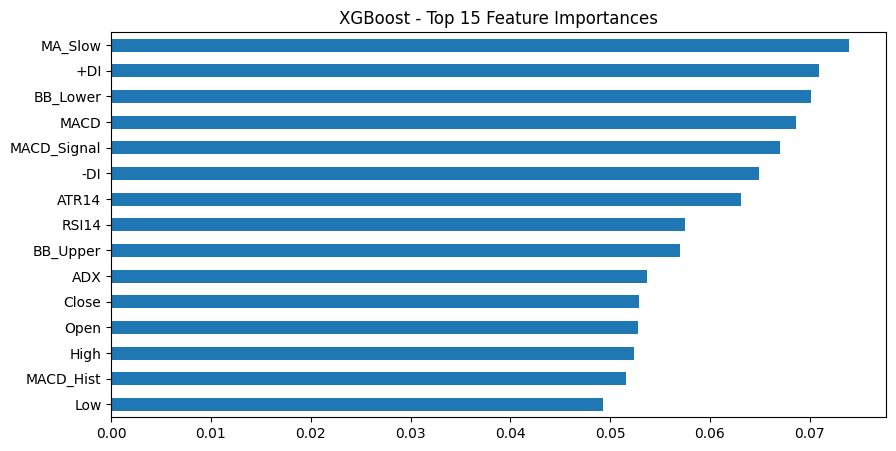

In [21]:
# ============================================================
# 🧩 Cell 6 — XGBoost Classifier
# ============================================================

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Split features and target
X = df_ready.drop(columns=["Timestamp", "target"], errors="ignore")
y = df_ready["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Model
xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_xgb),
    "precision": precision_score(y_test, y_pred_xgb, zero_division=0),
    "recall": recall_score(y_test, y_pred_xgb, zero_division=0),
    "f1": f1_score(y_test, y_pred_xgb, zero_division=0),
}
print("\n📘 XGBoost Performance:")
print(xgb_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Feature Importance
import matplotlib.pyplot as plt
importances = xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
feat_imp.head(15).plot(kind="barh")
plt.title("XGBoost - Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()



📘 RandomForest Performance:
{'accuracy': 0.39655172413793105, 'precision': 0.375, 'recall': 1.0, 'f1': 0.5454545454545454}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.05      0.10        37
           1       0.38      1.00      0.55        21

    accuracy                           0.40        58
   macro avg       0.69      0.53      0.32        58
weighted avg       0.77      0.40      0.26        58



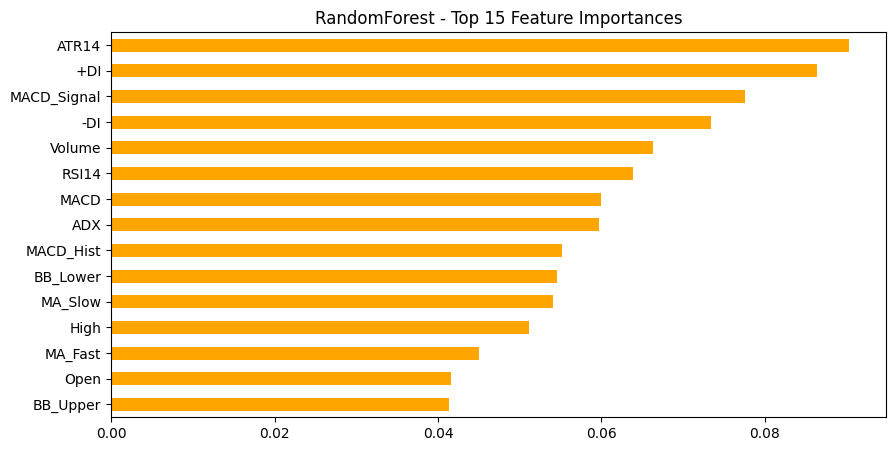

In [22]:
# ============================================================
# 🧩 Cell 7 — Random Forest Classifier
# ============================================================

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

rf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "recall": recall_score(y_test, y_pred_rf, zero_division=0),
    "f1": f1_score(y_test, y_pred_rf, zero_division=0),
}
print("\n📘 RandomForest Performance:")
print(rf_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Feature Importance
importances_rf = rf_model.feature_importances_
feat_imp_rf = pd.Series(importances_rf, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
feat_imp_rf.head(15).plot(kind="barh", color="orange")
plt.title("RandomForest - Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [23]:
# ============================================================
# 🧩 Cell 8 — Logistic Regression (Baseline Linear Model)
# ============================================================

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    solver="liblinear",
    C=1.0,
    random_state=42,
)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

lr_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "recall": recall_score(y_test, y_pred_lr, zero_division=0),
    "f1": f1_score(y_test, y_pred_lr, zero_division=0),
}
print("\n📘 LogisticRegression Performance:")
print(lr_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))



📘 LogisticRegression Performance:
{'accuracy': 0.41379310344827586, 'precision': 0.37735849056603776, 'recall': 0.9523809523809523, 'f1': 0.5405405405405406}

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.11      0.19        37
           1       0.38      0.95      0.54        21

    accuracy                           0.41        58
   macro avg       0.59      0.53      0.37        58
weighted avg       0.65      0.41      0.32        58




📘 Ensemble Weighted Model Performance:
{'accuracy': 0.3793103448275862, 'precision': 0.36363636363636365, 'recall': 0.9523809523809523, 'f1': 0.5263157894736842}

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.05      0.10        37
           1       0.36      0.95      0.53        21

    accuracy                           0.38        58
   macro avg       0.52      0.50      0.31        58
weighted avg       0.56      0.38      0.25        58



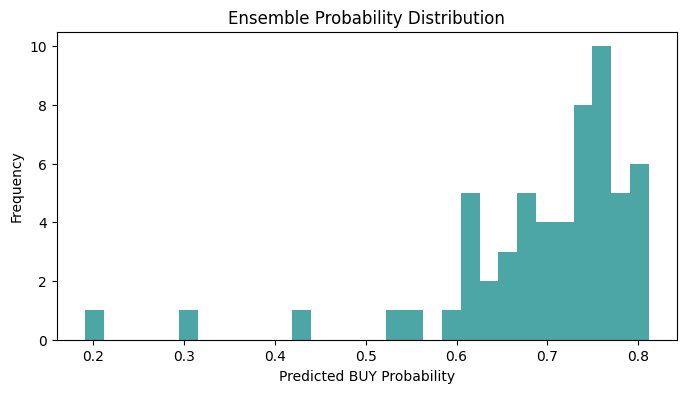

,Timestamp,Actual,Ensemble_Prob,Predicted
229,2025-09-19 16:00:00,0,0.191530,0
230,2025-09-22 12:00:00,0,0.301006,0
231,2025-09-22 16:00:00,0,0.545660,1
232,2025-09-23 12:00:00,1,0.437589,0
233,2025-09-23 16:00:00,0,0.588811,1
234,2025-09-24 12:00:00,0,0.535677,1
235,2025-09-24 16:00:00,0,0.612503,1
236,2025-09-25 12:00:00,0,0.621764,1
237,2025-09-25 16:00:00,0,0.762355,1
238,2025-09-26 12:00:00,0,0.747760,1


In [25]:
# ============================================================
# 🧩 Cell 9 — Weighted Ensemble (XGB + RF + LR)
# ============================================================

# You can tune these weights after checking individual performance
w_xgb = 0.4
w_rf  = 0.35
w_lr  = 0.25

ensemble_prob = (
    w_xgb * y_prob_xgb +
    w_rf * y_prob_rf +
    w_lr * y_prob_lr
)
y_pred_ensemble = (ensemble_prob > 0.5).astype(int)

ensemble_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_ensemble),
    "precision": precision_score(y_test, y_pred_ensemble, zero_division=0),
    "recall": recall_score(y_test, y_pred_ensemble, zero_division=0),
    "f1": f1_score(y_test, y_pred_ensemble, zero_division=0),
}

print("\n📘 Ensemble Weighted Model Performance:")
print(ensemble_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_ensemble))

plt.figure(figsize=(8, 4))
plt.hist(ensemble_prob, bins=30, color="teal", alpha=0.7)
plt.title("Ensemble Probability Distribution")
plt.xlabel("Predicted BUY Probability")
plt.ylabel("Frequency")
plt.show()

# Save predictions to DataFrame for analysis
ensemble_df = pd.DataFrame({
    "Timestamp": df_ready["Timestamp"].iloc[y_test.index],
    "Actual": y_test.values,
    "Ensemble_Prob": ensemble_prob,
    "Predicted": y_pred_ensemble,
})
display(ensemble_df.head(10))


📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
✅ Training on 796 / Testing on 200 samples
Target distribution:
target
0    79.417671
1    20.582329
Name: proportion, dtype: float64



d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



⏱️ XGBoost trained in 1.15s

📘 XGBoost Performance:
{'accuracy': 0.73, 'precision': 0.32, 'recall': 0.1778, 'f1': 0.2286}

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       155
           1       0.32      0.18      0.23        45

    accuracy                           0.73       200
   macro avg       0.55      0.53      0.53       200
weighted avg       0.68      0.73      0.70       200



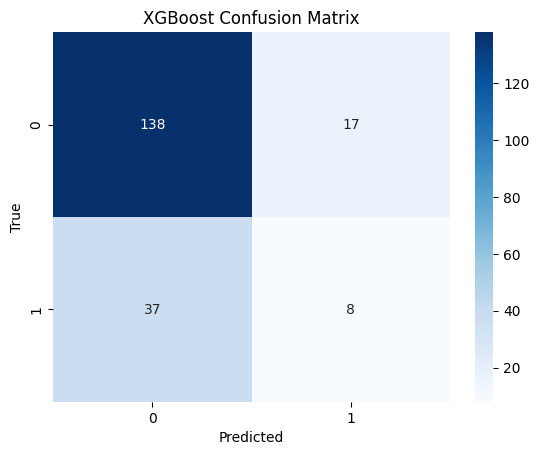


⏱️ RandomForest trained in 0.556s

📘 RandomForest Performance:
{'accuracy': 0.77, 'precision': 0.4286, 'recall': 0.0667, 'f1': 0.1154}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.87       155
           1       0.43      0.07      0.12        45

    accuracy                           0.77       200
   macro avg       0.61      0.52      0.49       200
weighted avg       0.70      0.77      0.70       200



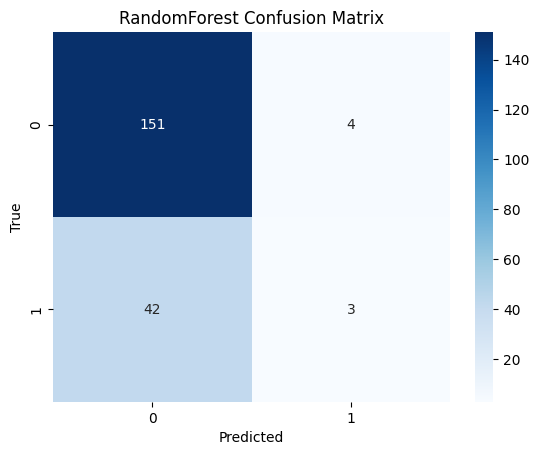


⏱️ LogisticRegression trained in 0.077s

📘 LogisticRegression Performance:
{'accuracy': 0.325, 'precision': 0.2152, 'recall': 0.7556, 'f1': 0.335}

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.20      0.31       155
           1       0.22      0.76      0.33        45

    accuracy                           0.33       200
   macro avg       0.48      0.48      0.32       200
weighted avg       0.62      0.33      0.32       200



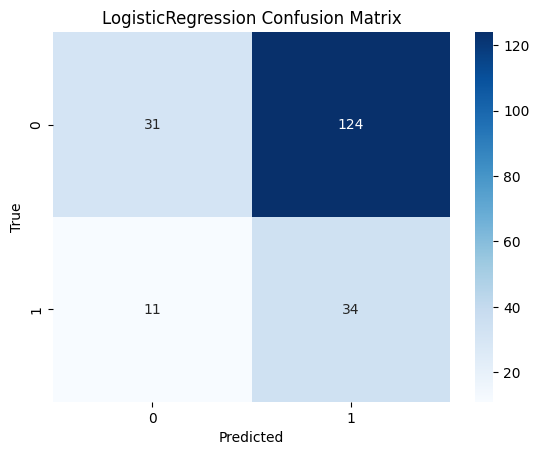


📘 Ensemble Weighted Model Performance:
{'accuracy': 0.77, 'precision': 0.3333, 'recall': 0.0222, 'f1': 0.0417}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       155
           1       0.33      0.02      0.04        45

    accuracy                           0.77       200
   macro avg       0.55      0.50      0.46       200
weighted avg       0.68      0.77      0.68       200



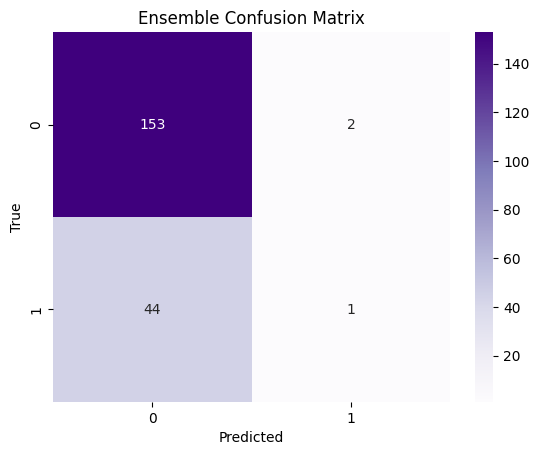

In [30]:
# ============================================================
# 🧩 Cell 10 — Precision-Optimized Quant Model (BUY / NOACTION)
# ============================================================

import os, time, json
import numpy as np, pandas as pd
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# CONFIG
# ----------------------------
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"     # <— change if needed
TIMEFRAME = "30min"
LOOKBACK = 60
PRICE_MOVE_THRESHOLD = 0.004   # ↑ stronger move = cleaner BUY label

FEATURE_COLS = [
    "Open","High","Low","Close","Volume",
    "RSI14","MACD","MACD_Signal","MACD_Hist",
    "MA_Fast","MA_Slow","ATR14","ADX","+DI","-DI",
    "BB_Upper","BB_Lower"
]

# ----------------------------
# LOAD + LABEL
# ----------------------------
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    path = os.path.join(folder, sorted(files)[-1])
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").dropna().reset_index(drop=True)
    return df

def label_data(df: pd.DataFrame, threshold: float = 0.004):
    df = df.copy()
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna(subset=["target"]).reset_index(drop=True)

# ----------------------------
# FEATURE ENGINEERING
# ----------------------------
def feature_engineer(df):
    df = df.copy()
    # deltas
    df["RSI_change"]  = df["RSI14"].diff()
    df["MACD_diff"]   = df["MACD"] - df["MACD_Signal"]
    df["ADX_change"]  = df["ADX"].diff()
    df["BB_width"]    = df["BB_Upper"] - df["BB_Lower"]

    # lags
    for col in ["RSI14","MACD","ADX"]:
        for lag in [1,2,3]:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df.dropna().reset_index(drop=True)

# ----------------------------
# BUILD FEATURE MATRIX
# ----------------------------
def build_matrix(df):
    X = df.drop(columns=["Timestamp","ret","target"], errors="ignore")
    y = df["target"]
    return X, y

# ----------------------------
# TRAIN / EVAL
# ----------------------------
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        "accuracy":  round(accuracy_score(y_test, y_pred),4),
        "precision": round(precision_score(y_test, y_pred,zero_division=0),4),
        "recall":    round(recall_score(y_test, y_pred,zero_division=0),4),
        "f1":        round(f1_score(y_test, y_pred,zero_division=0),4),
    }
    print(f"\n📘 {name} Performance:\n{metrics}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return metrics, y_pred

# ----------------------------
# MAIN PIPELINE
# ----------------------------
df = load_csv(STOCK_CODE, TIMEFRAME)
df = label_data(df, PRICE_MOVE_THRESHOLD)
df = feature_engineer(df)

X, y = build_matrix(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"✅ Training on {len(X_train)} / Testing on {len(X_test)} samples")
print(f"Target distribution:\n{y.value_counts(normalize=True)*100}\n")

# ----------------------------
# MODELS (with class balance)
# ----------------------------
models = {
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=5, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, gamma=0.5,
        min_child_weight=3, eval_metric="logloss",
        use_label_encoder=False, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=6, class_weight="balanced", n_jobs=-1, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        solver="liblinear", class_weight="balanced", C=1.0
    ),
}

# ----------------------------
# TRAIN + EVALUATE EACH MODEL
# ----------------------------
probs = {}
weights = {"XGBoost":0.5, "RandomForest":0.3, "LogisticRegression":0.2}

for name, model in models.items():
    start = time.perf_counter()
    model.fit(X_train, y_train)
    elapsed = round(time.perf_counter()-start,3)
    print(f"\n⏱️ {name} trained in {elapsed}s")
    metrics, _ = evaluate_model(name, model, X_test, y_test)
    probs[name] = model.predict_proba(X_test)[:,1]

# ----------------------------
# ENSEMBLE (weighted probabilities)
# ----------------------------
ensemble_prob = sum(weights[m]*probs[m] for m in probs)
y_pred_ens = (ensemble_prob > 0.65).astype(int)

ensemble_metrics = {
    "accuracy":  round(accuracy_score(y_test, y_pred_ens),4),
    "precision": round(precision_score(y_test, y_pred_ens,zero_division=0),4),
    "recall":    round(recall_score(y_test, y_pred_ens,zero_division=0),4),
    "f1":        round(f1_score(y_test, y_pred_ens,zero_division=0),4),
}

print("\n📘 Ensemble Weighted Model Performance:")
print(ensemble_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_ens))

cm = confusion_matrix(y_test, y_pred_ens)
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples")
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
✅ Training on 796 / Testing on 200 samples
Target distribution:
target
0    79.417671
1    20.582329
Name: proportion, dtype: float64



d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:57:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



⏱️ XGBoost trained in 3.105s

📘 XGBoost Performance:
{'accuracy': 0.73, 'precision': 0.3333, 'recall': 0.2, 'f1': 0.25}

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.84       155
           1       0.33      0.20      0.25        45

    accuracy                           0.73       200
   macro avg       0.56      0.54      0.54       200
weighted avg       0.69      0.73      0.70       200



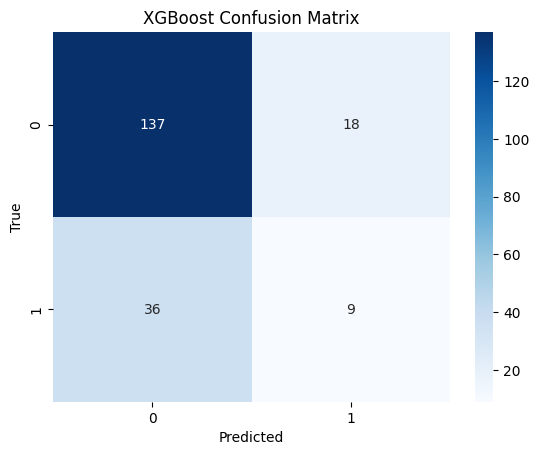


⏱️ RandomForest trained in 0.917s

📘 RandomForest Performance:
{'accuracy': 0.775, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87       155
           1       0.00      0.00      0.00        45

    accuracy                           0.78       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.60      0.78      0.68       200



d:\ANACONDA\envs\agentic\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\ANACONDA\envs\agentic\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\ANACONDA\envs\agentic\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


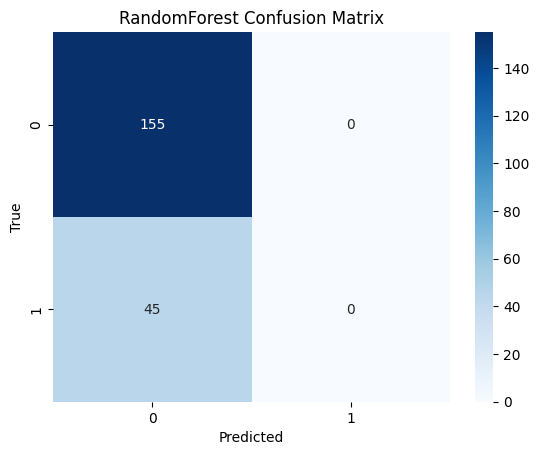


⏱️ LogisticRegression trained in 0.146s

📘 LogisticRegression Performance:
{'accuracy': 0.325, 'precision': 0.2152, 'recall': 0.7556, 'f1': 0.335}

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.20      0.31       155
           1       0.22      0.76      0.33        45

    accuracy                           0.33       200
   macro avg       0.48      0.48      0.32       200
weighted avg       0.62      0.33      0.32       200



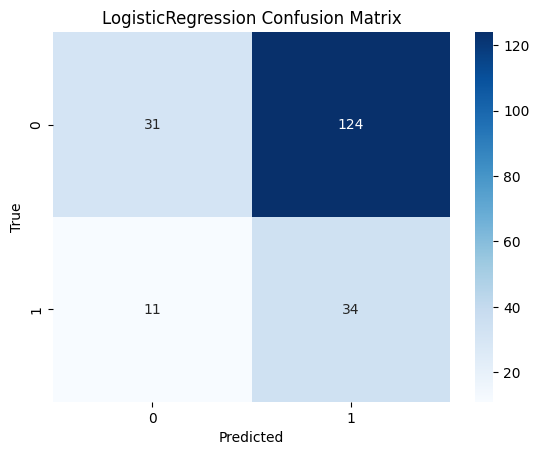


⚖️ Dynamic Ensemble Weights (F1-normalized): {'XGBoost': 0.4273504273504274, 'RandomForest': 0.0, 'LogisticRegression': 0.5726495726495727}

🔍 Threshold Scan (Precision / Recall tradeoff):
  Thr=0.45 → Precision=0.281, Recall=0.400, F1=0.330
  Thr=0.50 → Precision=0.333, Recall=0.311, F1=0.322
  Thr=0.55 → Precision=0.375, Recall=0.267, F1=0.312
  Thr=0.60 → Precision=0.364, Recall=0.178, F1=0.239
  Thr=0.65 → Precision=0.385, Recall=0.111, F1=0.172

✅ Best threshold based on F1 = 0.45

📘 Final Ensemble Model Performance (Adaptive Threshold):
{'accuracy': 0.635, 'precision': 0.2812, 'recall': 0.4, 'f1': 0.3303}

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75       155
           1       0.28      0.40      0.33        45

    accuracy                           0.64       200
   macro avg       0.54      0.55      0.54       200
weighted avg       0.68      0.64      0.65       200



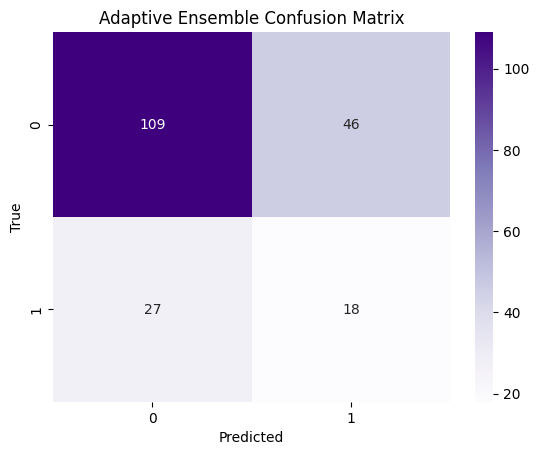

In [31]:
# ============================================================
# 🧩 Cell 10 — Enhanced Precision Quant Model (BUY / NOACTION)
# ============================================================

import os, time, json
import numpy as np, pandas as pd
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# CONFIG
# ----------------------------
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"     # ← change if needed
TIMEFRAME = "30min"
LOOKBACK = 60
PRICE_MOVE_THRESHOLD = 0.004   # ↑ 0.4% = BUY signal threshold

FEATURE_COLS = [
    "Open","High","Low","Close","Volume",
    "RSI14","MACD","MACD_Signal","MACD_Hist",
    "MA_Fast","MA_Slow","ATR14","ADX","+DI","-DI",
    "BB_Upper","BB_Lower"
]

# ----------------------------
# LOAD + LABEL
# ----------------------------
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"No CSV found for {stock_code} {tf}")
    path = os.path.join(folder, sorted(files)[-1])
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").dropna().reset_index(drop=True)
    return df

def label_data(df: pd.DataFrame, threshold: float = 0.004):
    df = df.copy()
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna(subset=["target"]).reset_index(drop=True)

# ----------------------------
# FEATURE ENGINEERING
# ----------------------------
def feature_engineer(df):
    df = df.copy()
    # deltas
    df["RSI_change"]  = df["RSI14"].diff()
    df["MACD_diff"]   = df["MACD"] - df["MACD_Signal"]
    df["ADX_change"]  = df["ADX"].diff()
    df["BB_width"]    = df["BB_Upper"] - df["BB_Lower"]
    # lags
    for col in ["RSI14","MACD","ADX"]:
        for lag in [1,2,3]:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df.dropna().reset_index(drop=True)

# ----------------------------
# BUILD FEATURE MATRIX
# ----------------------------
def build_matrix(df):
    X = df.drop(columns=["Timestamp","ret","target"], errors="ignore")
    y = df["target"]
    return X, y

# ----------------------------
# TRAIN / EVAL
# ----------------------------
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        "accuracy":  round(accuracy_score(y_test, y_pred),4),
        "precision": round(precision_score(y_test, y_pred,zero_division=0),4),
        "recall":    round(recall_score(y_test, y_pred,zero_division=0),4),
        "f1":        round(f1_score(y_test, y_pred,zero_division=0),4),
    }
    print(f"\n📘 {name} Performance:\n{metrics}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return metrics, y_pred

# ----------------------------
# MAIN PIPELINE
# ----------------------------
df = load_csv(STOCK_CODE, TIMEFRAME)
df = label_data(df, PRICE_MOVE_THRESHOLD)
df = feature_engineer(df)

X, y = build_matrix(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"✅ Training on {len(X_train)} / Testing on {len(X_test)} samples")
print(f"Target distribution:\n{y.value_counts(normalize=True)*100}\n")

# ----------------------------
# MODELS (class balancing)
# ----------------------------
pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

models = {
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, gamma=0.3,
        min_child_weight=3, eval_metric="logloss",
        use_label_encoder=False, scale_pos_weight=pos_weight,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=250, max_depth=8, class_weight="balanced",
        n_jobs=-1, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        solver="liblinear", class_weight="balanced", C=1.0, random_state=42
    ),
}

# ----------------------------
# TRAIN + EVALUATE
# ----------------------------
probs, f1_scores = {}, {}

for name, model in models.items():
    start = time.perf_counter()
    model.fit(X_train, y_train)
    elapsed = round(time.perf_counter()-start,3)
    print(f"\n⏱️ {name} trained in {elapsed}s")
    metrics, _ = evaluate_model(name, model, X_test, y_test)
    probs[name] = model.predict_proba(X_test)[:,1]
    f1_scores[name] = metrics["f1"]

# ----------------------------
# DYNAMIC WEIGHTS (based on F1)
# ----------------------------
total_f1 = sum(f1_scores.values())
weights = {k: v/total_f1 for k,v in f1_scores.items()}
print(f"\n⚖️ Dynamic Ensemble Weights (F1-normalized): {weights}")

# ----------------------------
# ADAPTIVE THRESHOLD SCAN
# ----------------------------
ensemble_prob = sum(weights[m]*probs[m] for m in probs)
thresholds = [0.45, 0.5, 0.55, 0.6, 0.65]
results = []

print("\n🔍 Threshold Scan (Precision / Recall tradeoff):")
for thr in thresholds:
    y_pred_thr = (ensemble_prob > thr).astype(int)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec  = recall_score(y_test, y_pred_thr, zero_division=0)
    f1   = f1_score(y_test, y_pred_thr, zero_division=0)
    results.append((thr, prec, rec, f1))
    print(f"  Thr={thr:.2f} → Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

# Choose threshold maximizing F1
best_thr = max(results, key=lambda x: x[3])[0]
print(f"\n✅ Best threshold based on F1 = {best_thr:.2f}")

# ----------------------------
# FINAL ENSEMBLE PERFORMANCE
# ----------------------------
y_pred_final = (ensemble_prob > best_thr).astype(int)

ensemble_metrics = {
    "accuracy":  round(accuracy_score(y_test, y_pred_final),4),
    "precision": round(precision_score(y_test, y_pred_final,zero_division=0),4),
    "recall":    round(recall_score(y_test, y_pred_final,zero_division=0),4),
    "f1":        round(f1_score(y_test, y_pred_final,zero_division=0),4),
}

print("\n📘 Final Ensemble Model Performance (Adaptive Threshold):")
print(ensemble_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples")
plt.title("Adaptive Ensemble Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


# cell 11 final code

📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
✅ Training on 611 / Testing on 153 samples
Target distribution:
target
0    78.272251
1    21.727749
Name: proportion, dtype: float64



d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:47:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



⏱️ XGBoost trained in 1.25s

📘 XGBoost Performance:
{'accuracy': 0.732, 'precision': 0.4, 'recall': 0.1579, 'f1': 0.2264}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       115
           1       0.40      0.16      0.23        38

    accuracy                           0.73       153
   macro avg       0.58      0.54      0.53       153
weighted avg       0.68      0.73      0.69       153



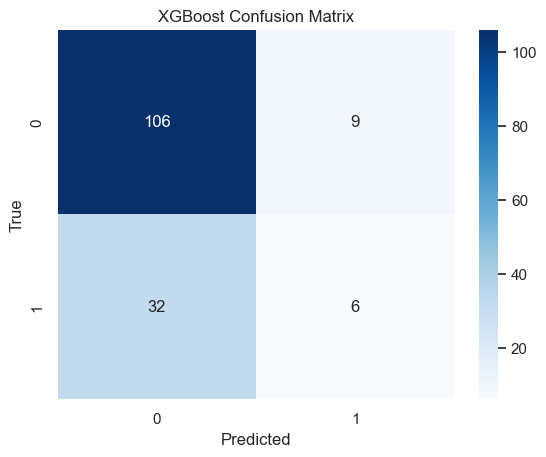

[LightGBM] [Info] Number of positive: 128, number of negative: 483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7479
[LightGBM] [Info] Number of data points in the train set: 611, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

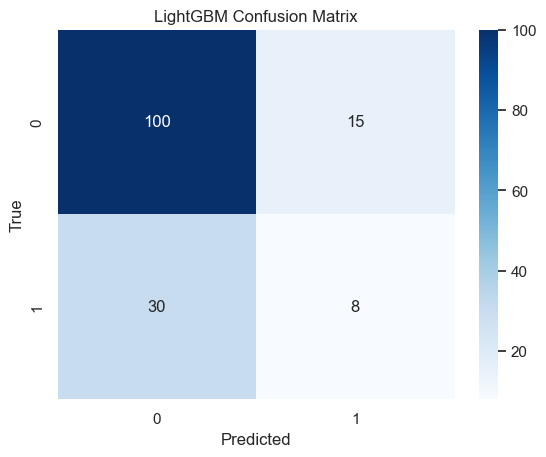


⏱️ LogisticRegression trained in 0.115s

📘 LogisticRegression Performance:
{'accuracy': 0.3399, 'precision': 0.2308, 'recall': 0.7105, 'f1': 0.3484}
              precision    recall  f1-score   support

           0       0.69      0.22      0.33       115
           1       0.23      0.71      0.35        38

    accuracy                           0.34       153
   macro avg       0.46      0.46      0.34       153
weighted avg       0.58      0.34      0.34       153



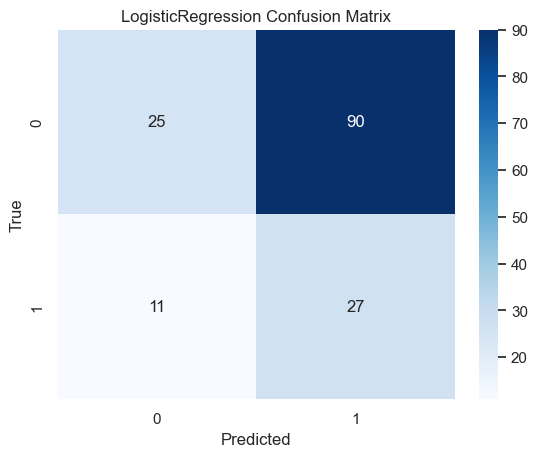


⚖️ Dynamic Ensemble Weights (F1-normalized): {'XGBoost': 0.2704575319555609, 'LightGBM': 0.3133436865368534, 'LogisticRegression': 0.4161987815075857}

🔍 Threshold Scan (Precision / Recall tradeoff):
  Thr=0.40 → Precision=0.292, Recall=0.368, F1=0.326
  Thr=0.45 → Precision=0.314, Recall=0.289, F1=0.301
  Thr=0.50 → Precision=0.286, Recall=0.211, F1=0.242
  Thr=0.55 → Precision=0.364, Recall=0.211, F1=0.267
  Thr=0.60 → Precision=0.412, Recall=0.184, F1=0.255
  Thr=0.65 → Precision=0.417, Recall=0.132, F1=0.200

✅ Best threshold based on F1 = 0.40

📘 Final Ensemble (Precision v2):
{'accuracy': 0.6209, 'precision': 0.2917, 'recall': 0.3684, 'f1': 0.3256}

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.70      0.74       115
           1       0.29      0.37      0.33        38

    accuracy                           0.62       153
   macro avg       0.53      0.54      0.53       153
weighted avg       0.65      0.62      

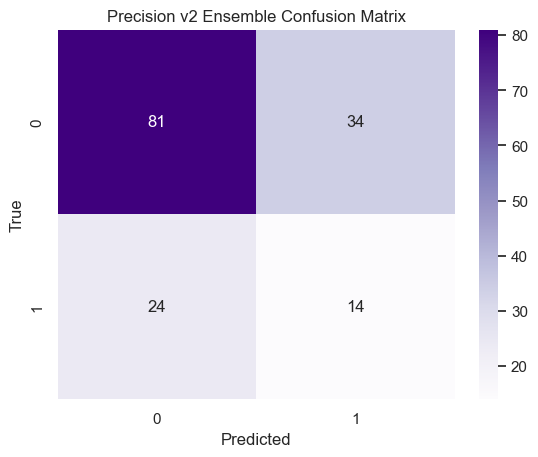

In [32]:
# ============================================================
# 🧩 Cell 11 — Precision v2 Quant Model (BUY / NOACTION)
# ============================================================

import os, time, json
import numpy as np, pandas as pd
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ============================================================
# CONFIG
# ============================================================
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"        # ← change if needed
TIMEFRAME = "30min"
PRICE_MOVE_THRESHOLD = 0.004   # 0.4% = BUY trigger
LOOKBACK = 60

# ============================================================
# LOAD + LABEL
# ============================================================
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"No CSV found for {stock_code} {tf}")
    path = os.path.join(folder, sorted(files)[-1])
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").dropna().reset_index(drop=True)
    return df

def label_data(df: pd.DataFrame, threshold: float = 0.004):
    df = df.copy()
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna(subset=["target"]).reset_index(drop=True)

# ============================================================
# FEATURE ENGINEERING — Candle Shape + Trend Features
# ============================================================
def feature_engineer(df):
    df = df.copy()

    # --- Candle structure
    df["Body"] = df["Close"] - df["Open"]
    df["UpperShadow"] = df["High"] - df[["Close","Open"]].max(axis=1)
    df["LowerShadow"] = df[["Close","Open"]].min(axis=1) - df["Low"]
    df["BodyRatio"] = df["Body"] / (df["High"] - df["Low"] + 1e-6)

    # --- Momentum & Trend
    df["MA_diff"] = df["MA_Fast"] - df["MA_Slow"]
    df["Slope_5"] = df["Close"].diff(5)
    df["RSI_change"] = df["RSI14"].diff()
    df["MACD_diff"] = df["MACD"] - df["MACD_Signal"]
    df["ADX_change"] = df["ADX"].diff()
    df["BB_width"] = df["BB_Upper"] - df["BB_Lower"]

    # --- Lagged indicators
    for col in ["RSI14","MACD","ADX"]:
        for lag in [1,2,3]:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    df = df.replace([np.inf,-np.inf], np.nan).dropna().reset_index(drop=True)
    return df

# ============================================================
# BUILD FEATURE MATRIX
# ============================================================
def build_matrix(df):
    X = df.drop(columns=["Timestamp","ret","target"], errors="ignore")
    y = df["target"]
    return X, y

# ============================================================
# MODEL TRAIN / EVAL
# ============================================================
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        "accuracy":  round(accuracy_score(y_test, y_pred),4),
        "precision": round(precision_score(y_test, y_pred,zero_division=0),4),
        "recall":    round(recall_score(y_test, y_pred,zero_division=0),4),
        "f1":        round(f1_score(y_test, y_pred,zero_division=0),4),
    }
    print(f"\n📘 {name} Performance:\n{metrics}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return metrics

# ============================================================
# MAIN PIPELINE
# ============================================================
df = load_csv(STOCK_CODE, TIMEFRAME)
df = label_data(df, PRICE_MOVE_THRESHOLD)
df = feature_engineer(df)

# --- Volatility / Regime Filter
vol_ma = df["ATR14"].rolling(50).mean()
df = df.loc[df["ATR14"] > 0.8 * vol_ma]  # keep only volatile regimes
df = df.reset_index(drop=True)

X, y = build_matrix(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"✅ Training on {len(X_train)} / Testing on {len(X_test)} samples")
print(f"Target distribution:\n{y.value_counts(normalize=True)*100}\n")

# ============================================================
# MODEL DEFINITIONS
# ============================================================
pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

models = {
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, gamma=0.3,
        min_child_weight=3, eval_metric="logloss",
        use_label_encoder=False, scale_pos_weight=pos_weight, random_state=42
    ),
    "LightGBM": LGBMClassifier(
        num_leaves=31, learning_rate=0.05, n_estimators=400,
        class_weight="balanced", subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.3, reg_lambda=0.3, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        solver="liblinear", class_weight="balanced", C=1.0, random_state=42
    ),
}

# ============================================================
# TRAIN + EVALUATE
# ============================================================
probs, f1_scores = {}, {}

for name, model in models.items():
    start = time.perf_counter()
    model.fit(X_train, y_train)
    print(f"\n⏱️ {name} trained in {round(time.perf_counter()-start,3)}s")
    metrics = evaluate_model(name, model, X_test, y_test)
    f1_scores[name] = metrics["f1"]
    probs[name] = model.predict_proba(X_test)[:,1]

# ============================================================
# DYNAMIC WEIGHTS (based on F1)
# ============================================================
total_f1 = sum(f1_scores.values())
weights = {k: v/total_f1 for k,v in f1_scores.items()}
print(f"\n⚖️ Dynamic Ensemble Weights (F1-normalized): {weights}")

# ============================================================
# ADAPTIVE THRESHOLD SCAN
# ============================================================
ensemble_prob = sum(weights[m]*probs[m] for m in probs)
thresholds = np.arange(0.4, 0.7, 0.05)
results = []

print("\n🔍 Threshold Scan (Precision / Recall tradeoff):")
for thr in thresholds:
    y_pred_thr = (ensemble_prob > thr).astype(int)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec  = recall_score(y_test, y_pred_thr, zero_division=0)
    f1   = f1_score(y_test, y_pred_thr, zero_division=0)
    results.append((thr, prec, rec, f1))
    print(f"  Thr={thr:.2f} → Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

best_thr = max(results, key=lambda x: x[3])[0]
print(f"\n✅ Best threshold based on F1 = {best_thr:.2f}")

# ============================================================
# FINAL ENSEMBLE PERFORMANCE
# ============================================================
y_pred_final = (ensemble_prob > best_thr).astype(int)
ensemble_metrics = {
    "accuracy":  round(accuracy_score(y_test, y_pred_final),4),
    "precision": round(precision_score(y_test, y_pred_final,zero_division=0),4),
    "recall":    round(recall_score(y_test, y_pred_final,zero_division=0),4),
    "f1":        round(f1_score(y_test, y_pred_final,zero_division=0),4),
}
print("\n📘 Final Ensemble (Precision v2):")
print(ensemble_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples")
plt.title("Precision v2 Ensemble Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_4hour_2024-11-03_to_2025-11-03.csv
After ATR filter: 220 rows remain
✅ Training on 176 / Testing on 44 samples
Target distribution:
target
0    58.636364
1    41.363636
Name: proportion, dtype: float64



d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:22:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



⏱️ XGBoost trained in 0.881s

📘 XGBoost → acc:0.4545 prec:0.4167 rec:0.8333 f1:0.5556
              precision    recall  f1-score   support

           0       0.62      0.19      0.29        26
           1       0.42      0.83      0.56        18

    accuracy                           0.45        44
   macro avg       0.52      0.51      0.42        44
weighted avg       0.54      0.45      0.40        44



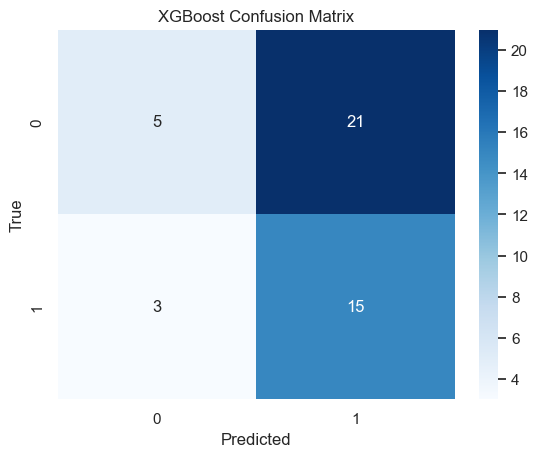

[LightGBM] [Info] Number of positive: 73, number of negative: 103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 176, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

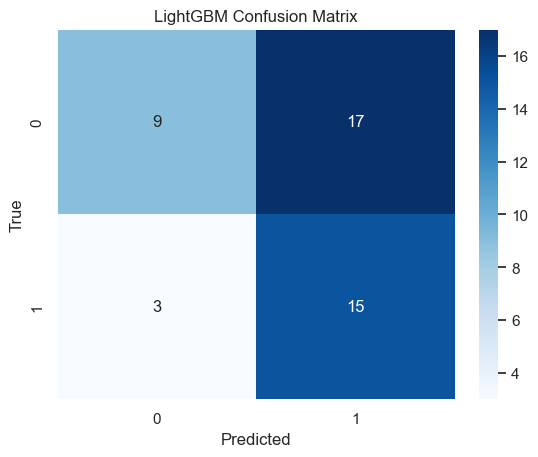


⏱️ LogisticRegression trained in 0.055s

📘 LogisticRegression → acc:0.5227 prec:0.3846 rec:0.2778 f1:0.3226
              precision    recall  f1-score   support

           0       0.58      0.69      0.63        26
           1       0.38      0.28      0.32        18

    accuracy                           0.52        44
   macro avg       0.48      0.49      0.48        44
weighted avg       0.50      0.52      0.51        44



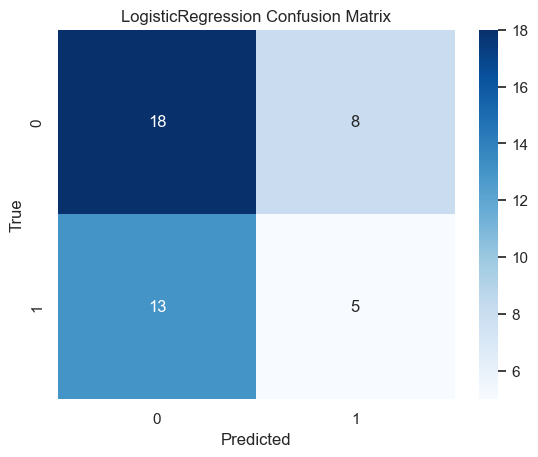


📘 Meta (stacking) @0.50 → acc:0.4318 prec:0.4054 rec:0.8333 f1:0.5455
              precision    recall  f1-score   support

           0       0.57      0.15      0.24        26
           1       0.41      0.83      0.55        18

    accuracy                           0.43        44
   macro avg       0.49      0.49      0.39        44
weighted avg       0.50      0.43      0.37        44



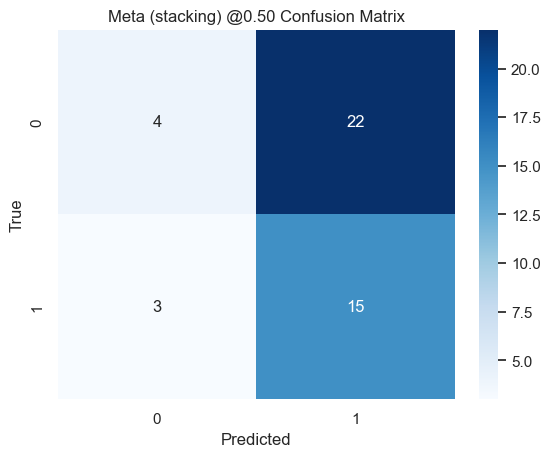


🔍 Meta threshold scan (choose best threshold by F1):
 Thr=0.35 → precision=0.410, recall=0.889, f1=0.561
 Thr=0.40 → precision=0.405, recall=0.833, f1=0.545
 Thr=0.45 → precision=0.405, recall=0.833, f1=0.545
 Thr=0.50 → precision=0.405, recall=0.833, f1=0.545
 Thr=0.55 → precision=0.429, recall=0.833, f1=0.566
 Thr=0.60 → precision=0.455, recall=0.833, f1=0.588
 Thr=0.65 → precision=0.469, recall=0.833, f1=0.600
 Thr=0.70 → precision=0.467, recall=0.778, f1=0.583

✅ Best meta threshold (by F1) = 0.65 with F1=0.6000

📘 Meta Final @ 0.65 → acc:0.5455 prec:0.4688 rec:0.8333 f1:0.6000
              precision    recall  f1-score   support

           0       0.75      0.35      0.47        26
           1       0.47      0.83      0.60        18

    accuracy                           0.55        44
   macro avg       0.61      0.59      0.54        44
weighted avg       0.63      0.55      0.53        44



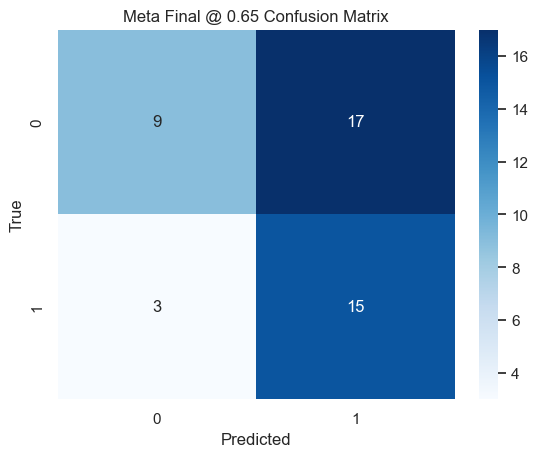


📦 Summary: {
  "stock_code": "FORCEMOT",
  "timeframe": "4hour",
  "generated_at": "2025-11-04T14:22:39.834917",
  "rows_after_filter": 220,
  "train_samples": 176,
  "test_samples": 44,
  "base_metrics": {
    "XGBoost": {
      "accuracy": 0.45454545454545453,
      "precision": 0.4166666666666667,
      "recall": 0.8333333333333334,
      "f1": 0.5555555555555556
    },
    "LightGBM": {
      "accuracy": 0.5454545454545454,
      "precision": 0.46875,
      "recall": 0.8333333333333334,
      "f1": 0.6
    },
    "LogisticRegression": {
      "accuracy": 0.5227272727272727,
      "precision": 0.38461538461538464,
      "recall": 0.2777777777777778,
      "f1": 0.3225806451612903
    }
  },
  "meta_metrics": {
    "accuracy": 0.5454545454545454,
    "precision": 0.46875,
    "recall": 0.8333333333333334,
    "f1": 0.6
  },
  "meta_best_threshold": 0.6499999999999999
}
💾 Summary saved → result\FORCEMOT\forcemot_precision_v3_summary.json


In [38]:
# ============================================================
# 🧩 Cell 12 — Precision v3 Quant Model (BUY / NOACTION) w/ Meta-Learner
# ============================================================
import os, time, json
import numpy as np, pandas as pd
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ----------------------------
# CONFIG
# ----------------------------
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"     # change as needed
TIMEFRAME = "4hour"
PRICE_MOVE_THRESHOLD = 0.004   # 0.4% up move = BUY
LOOKBACK = 60
ATR_FILTER_RATIO = 0.6        # loosened (was 0.8)

# ----------------------------
# CSV loader + labeling
# ----------------------------
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"No CSV found for {stock_code} {tf}")
    path = os.path.join(folder, sorted(files)[-1])
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True)
    return df

def label_data(df: pd.DataFrame, threshold: float = PRICE_MOVE_THRESHOLD):
    df = df.copy()
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna(subset=["target"]).reset_index(drop=True)

# ----------------------------
# feature engineering (v3)
# ----------------------------
def feature_engineer_v3(df: pd.DataFrame):
    df = df.copy()
    # Candle shape
    df["Body"] = df["Close"] - df["Open"]
    df["UpperShadow"] = df["High"] - df[["Close","Open"]].max(axis=1)
    df["LowerShadow"] = df[["Close","Open"]].min(axis=1) - df["Low"]
    df["BodyRatio"] = df["Body"] / (df["High"] - df["Low"] + 1e-9)

    # Standard momentum/trend
    df["MA_diff"] = df["MA_Fast"] - df["MA_Slow"]
    df["Slope_5"] = df["Close"].diff(5)
    df["RSI_change"] = df["RSI14"].diff()
    df["MACD_diff"] = df["MACD"] - df["MACD_Signal"]
    df["ADX_change"] = df["ADX"].diff()
    df["BB_width"] = df["BB_Upper"] - df["BB_Lower"]

    # Acceleration (second derivative)
    df["RSI_accel"] = df["RSI_change"].diff()
    df["MACD_accel"] = df["MACD_diff"].diff()

    # Reversal / pattern flags (simple)
    df["BullishReversal"] = (
        (df["Body"] > 0)
        & (df["LowerShadow"] > df["UpperShadow"])
        & (df["RSI14"] < 50)
    ).astype(int)

    # Lag features
    for col in ["RSI14","MACD","ADX","MA_diff","Slope_5"]:
        for lag in [1,2,3]:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # drop infinities and NA (from diffs & lags)
    df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
    return df

# ----------------------------
# build feature matrix
# ----------------------------
def build_Xy(df):
    X = df.drop(columns=["Timestamp","ret","target"], errors="ignore")
    y = df["target"].astype(int)
    return X, y

# ----------------------------
# evaluation helper
# ----------------------------
def print_eval(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n📘 {name} → acc:{acc:.4f} prec:{prec:.4f} rec:{rec:.4f} f1:{f1:.4f}")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}

# ----------------------------
# main pipeline
# ----------------------------
df = load_csv(STOCK_CODE, TIMEFRAME)
df = label_data(df, PRICE_MOVE_THRESHOLD)
df = feature_engineer_v3(df)

# volatility / regime filter (looser)
vol_ma = df["ATR14"].rolling(50).mean()
df = df.loc[df["ATR14"] > ATR_FILTER_RATIO * vol_ma].reset_index(drop=True)
print(f"After ATR filter: {len(df)} rows remain")

X, y = build_Xy(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"✅ Training on {len(X_train)} / Testing on {len(X_test)} samples")
print(f"Target distribution:\n{y.value_counts(normalize=True)*100}\n")

# ----------------------------
# define base models (class weight / pos weight)
# ----------------------------
pos_weight = max(1.0, len(y_train[y_train==0]) / max(1, len(y_train[y_train==1])))

base_models = {
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=5, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, gamma=0.2,
        min_child_weight=3, eval_metric="logloss",
        use_label_encoder=False, scale_pos_weight=pos_weight, random_state=42
    ),
    "LightGBM": LGBMClassifier(
        num_leaves=31, learning_rate=0.05, n_estimators=300,
        class_weight="balanced", subsample=0.8, reg_alpha=0.2, reg_lambda=0.2,
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        solver="liblinear", class_weight="balanced", C=1.0, random_state=42
    ),
}

# ----------------------------
# train base models and collect probs (train & test)
# ----------------------------
train_probs = {}
test_probs = {}
base_metrics = {}

for name, model in base_models.items():
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t_elapsed = round(time.perf_counter() - t0, 3)
    print(f"\n⏱️ {name} trained in {t_elapsed}s")
    # predictions on test
    probs_test = model.predict_proba(X_test)[:,1]
    probs_train = model.predict_proba(X_train)[:,1]
    test_probs[name] = probs_test
    train_probs[name] = probs_train
    # binary predict on test using 0.5 threshold for reporting
    y_pred_test = (probs_test > 0.5).astype(int)
    base_metrics[name] = print_eval(name, y_test, y_pred_test)

# ----------------------------
# simple stacking (meta-learner): train on base probs (train set), predict on test
# ----------------------------
# Build meta training matrix using base model probs on X_train
meta_X_train = pd.DataFrame({name: train_probs[name] for name in train_probs})
meta_X_test  = pd.DataFrame({name: test_probs[name]  for name in test_probs})
# Train meta logistic regression
meta_model = LogisticRegression(solver="liblinear", C=1.0, class_weight="balanced", random_state=42)
meta_model.fit(meta_X_train, y_train)
meta_probs_test = meta_model.predict_proba(meta_X_test)[:,1]
# Evaluate meta baseline with 0.5 threshold
y_meta_pred50 = (meta_probs_test > 0.5).astype(int)
meta_metrics50 = print_eval("Meta (stacking) @0.50", y_test, y_meta_pred50)

# ----------------------------
# adaptive threshold scan on meta probabilities
# ----------------------------
print("\n🔍 Meta threshold scan (choose best threshold by F1):")
best = (None, -1.0, None)  # thr, f1, metrics
results = []
for thr in np.arange(0.35, 0.71, 0.05):
    y_pred_thr = (meta_probs_test > thr).astype(int)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec = recall_score(y_test, y_pred_thr, zero_division=0)
    f1 = f1_score(y_test, y_pred_thr, zero_division=0)
    results.append((thr, prec, rec, f1))
    print(f" Thr={thr:.2f} → precision={prec:.3f}, recall={rec:.3f}, f1={f1:.3f}")
    if f1 > best[1]:
        best = (thr, f1, {"precision":prec, "recall":rec})

best_thr = best[0]
print(f"\n✅ Best meta threshold (by F1) = {best_thr:.2f} with F1={best[1]:.4f}")

# ----------------------------
# Final meta predictions (chosen threshold)
# ----------------------------
y_meta_final = (meta_probs_test > best_thr).astype(int)
final_metrics = print_eval(f"Meta Final @ {best_thr:.2f}", y_test, y_meta_final)

# ----------------------------
# print summary
# ----------------------------
summary = {
    "stock_code": STOCK_CODE,
    "timeframe": TIMEFRAME,
    "generated_at": datetime.now().isoformat(),
    "rows_after_filter": len(df),
    "train_samples": len(X_train),
    "test_samples": len(X_test),
    "base_metrics": base_metrics,
    "meta_metrics": final_metrics,
    "meta_best_threshold": best_thr
}
print("\n📦 Summary:", json.dumps(summary, indent=2))

# optionally save summary JSON and model probs
out_dir = os.path.join("result", STOCK_CODE.upper())
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, f"{STOCK_CODE.lower()}_precision_v3_summary.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"💾 Summary saved → {os.path.join(out_dir, f'{STOCK_CODE.lower()}_precision_v3_summary.json')}")


📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv


d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:23:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 160, number of negative: 638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 61, number of negative: 215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

C:\temp\ipykernel_10032\170421597.py:156: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta("1H")
d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



⚙️ Fusion Model Performance: {'accuracy': 0.6667, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
✅ Best threshold: 0.5


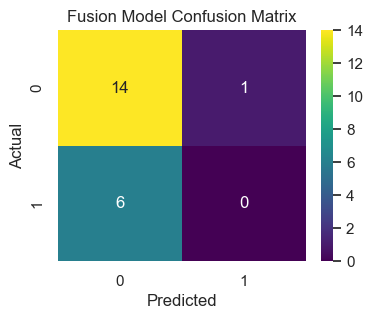


💾 Fusion results saved → result/FORCEMOT\forcemot_fusion_result.json


In [45]:
# ============================================================
# 🧩 Cell 14 — Multi-Timeframe Fusion Quant Model (CSV-based, Merge-Safe)
# ============================================================

import os, json, time
import numpy as np, pandas as pd
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"
TIMEFRAMES = ["30min", "45min"]
RESULT_PATH = f"result/{STOCK_CODE}"
os.makedirs(RESULT_PATH, exist_ok=True)

PRICE_MOVE_THRESHOLD = 0.004
LOOKBACK = 60

# ------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------
def load_csv(stock_code, tf):
    folder = os.path.join(BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        print(f"⚠️ Missing CSV for {tf}")
        return pd.DataFrame()
    path = os.path.join(folder, sorted(files)[-1])
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").dropna().reset_index(drop=True)
    return df


def label_data(df, threshold=PRICE_MOVE_THRESHOLD):
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna().reset_index(drop=True)


def build_features(df):
    df["RSI_change"] = df["RSI14"].diff()
    df["MACD_diff"] = df["MACD"] - df["MACD_Signal"]
    df["ADX_change"] = df["ADX"].diff()
    df["BB_width"] = df["BB_Upper"] - df["BB_Lower"]
    df = df.dropna().reset_index(drop=True)
    X = df.drop(columns=["Timestamp","ret","target"], errors="ignore")
    y = df["target"]
    return X, y, df["Timestamp"]


def train_models(X_train, y_train):
    models = {
        "XGBoost": XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
            use_label_encoder=False, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=200, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, class_weight="balanced"
        ),
        "LogisticRegression": LogisticRegression(solver="liblinear", class_weight="balanced")
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
    return models


def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    metrics = {
        "accuracy": round(accuracy_score(y_test, y_pred), 4),
        "precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_test, y_pred, zero_division=0), 4)
    }
    print(f"\n📘 {name} Performance: {metrics}")
    return metrics, y_prob


# ------------------------------------------------------------
# STEP 1 — Train Each Timeframe Model
# ------------------------------------------------------------
tf_results = {}
prob_dfs = []

for tf in TIMEFRAMES:
    df = load_csv(STOCK_CODE, tf)
    if df.empty:
        continue

    df = label_data(df)
    X, y, ts = build_features(df)
    X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(
        X, y, ts, test_size=0.2, shuffle=False
    )

    models = train_models(X_train, y_train)

    tf_metrics, tf_probs = {}, []
    for name, model in models.items():
        metrics, y_prob = evaluate_model(name, model, X_test, y_test)
        tf_metrics[name] = metrics
        tf_probs.append(y_prob)

    # Meta-ensemble for this timeframe
    meta_prob = np.mean(tf_probs, axis=0)
    meta_pred = (meta_prob > 0.5).astype(int)
    meta_metrics = {
        "accuracy": round(accuracy_score(y_test, meta_pred), 4),
        "precision": round(precision_score(y_test, meta_pred, zero_division=0), 4),
        "recall": round(recall_score(y_test, meta_pred, zero_division=0), 4),
        "f1": round(f1_score(y_test, meta_pred, zero_division=0), 4)
    }

    print(f"✅ {tf} Meta Model Performance: {meta_metrics}")
    tf_results[tf] = {"base_metrics": tf_metrics, "meta_metrics": meta_metrics}

    df_probs = pd.DataFrame({
        "Timestamp": ts_test.values,
        "target": y_test.values,
        f"prob_{tf}": meta_prob
    })
    prob_dfs.append(df_probs)

# ------------------------------------------------------------
# STEP 2 — Merge All Timeframes (Safe Merge)
# ------------------------------------------------------------
if not prob_dfs:
    raise ValueError("❌ No timeframe dataframes loaded.")

meta_df = prob_dfs[0]
for df in prob_dfs[1:]:
    df = df.drop(columns=["target"], errors="ignore")  # remove duplicate 'target'
    meta_df = pd.merge_asof(
        meta_df.sort_values("Timestamp"),
        df.sort_values("Timestamp"),
        on="Timestamp",
        direction="nearest",
        tolerance=pd.Timedelta("1H")
    )

meta_df = meta_df.dropna().reset_index(drop=True)

print(f"\n✅ Merged {len(meta_df)} aligned samples across {TIMEFRAMES}")
X_meta = meta_df[[f"prob_{tf}" for tf in TIMEFRAMES]]
y_meta = meta_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, shuffle=False)

# ------------------------------------------------------------
# STEP 3 — Train Fusion Meta-Model
# ------------------------------------------------------------
fusion_model = XGBClassifier(
    n_estimators=200, max_depth=3, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
    use_label_encoder=False
)
fusion_model.fit(X_train, y_train)
y_prob = fusion_model.predict_proba(X_test)[:, 1]

# threshold tuning
thresholds = np.arange(0.3, 0.8, 0.05)
best_thr, best_f1 = 0.5, 0
for thr in thresholds:
    y_pred = (y_prob > thr).astype(int)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    if f1 > best_f1:
        best_thr, best_f1 = thr, f1

y_pred = (y_prob > best_thr).astype(int)
fusion_metrics = {
    "accuracy": round(accuracy_score(y_test, y_pred), 4),
    "precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
    "recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
    "f1": round(f1_score(y_test, y_pred, zero_division=0), 4)
}

print(f"\n⚙️ Fusion Model Performance: {fusion_metrics}")
print(f"✅ Best threshold: {best_thr}")

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="viridis", fmt="d")
plt.title("Fusion Model Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ------------------------------------------------------------
# STEP 4 — SAVE RESULTS
# ------------------------------------------------------------
final_output = {
    "stock_code": STOCK_CODE,
    "generated_at": datetime.now().isoformat(),
    "timeframes": TIMEFRAMES,
    "samples_total": len(meta_df),
    "train_samples": len(X_train),
    "test_samples": len(X_test),
    "per_timeframe": tf_results,
    "fusion_metrics": fusion_metrics,
    "fusion_best_threshold": best_thr
}

save_path = os.path.join(RESULT_PATH, f"{STOCK_CODE.lower()}_fusion_result.json")
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(final_output, f, indent=2, ensure_ascii=False)

print(f"\n💾 Fusion results saved → {save_path}")


In [47]:
# ============================================================
# 🧩 Cell 16 — FULL PIPELINE: Multi-Timeframe Training + Vote Fusion
# ============================================================

import os, json, time
import numpy as np, pandas as pd
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

# ============================================================
# CONFIG
# ============================================================
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"
TIMEFRAMES = ["30min", "45min", "1hour", "4hour"]  # train all and fuse
PRICE_MOVE_THRESHOLD = 0.004
TEST_RATIO = 0.2

RESULT_PATH = f"result/{STOCK_CODE}"
os.makedirs(RESULT_PATH, exist_ok=True)

FEATURE_COLS = [
    "Open","High","Low","Close","Volume",
    "RSI14","MACD","MACD_Signal","MACD_Hist",
    "MA_Fast","MA_Slow","ATR14","ADX","+DI","-DI",
    "BB_Upper","BB_Lower"
]

# ============================================================
# HELPER FUNCTIONS
# ============================================================
def load_csv(stock_code, tf):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        print(f"⚠️ No CSV found for {stock_code} {tf}")
        return pd.DataFrame()
    path = os.path.join(folder, sorted(files)[-1])
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").dropna().reset_index(drop=True)
    return df

def label_data(df, threshold=PRICE_MOVE_THRESHOLD):
    df = df.copy()
    df["ret"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
    df["target"] = np.where(df["ret"] > threshold, 1, 0)
    return df.dropna().reset_index(drop=True)

def feature_engineer(df):
    df = df.copy()
    df["RSI_change"] = df["RSI14"].diff()
    df["MACD_diff"] = df["MACD"] - df["MACD_Signal"]
    df["ADX_change"] = df["ADX"].diff()
    df["BB_width"] = df["BB_Upper"] - df["BB_Lower"]
    return df.dropna().reset_index(drop=True)

def evaluate_model(y_true, y_pred):
    return {
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_true, y_pred, zero_division=0), 4)
    }

# ============================================================
# MAIN TRAINING LOOP PER TIMEFRAME
# ============================================================
results = {}
for tf in TIMEFRAMES:
    df = load_csv(STOCK_CODE, tf)
    if df.empty:
        continue
    df = label_data(df)
    df = feature_engineer(df)
    if len(df) < 200:
        print(f"⚠️ Skipping {tf} (too few samples: {len(df)})")
        continue

    X = df.drop(columns=["Timestamp", "ret", "target"], errors="ignore")
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, shuffle=False)

    print(f"\n🕒 Training {tf} — Samples: {len(X_train)} train / {len(X_test)} test")

    models = {
        "XGBoost": XGBClassifier(
            n_estimators=300, max_depth=5, learning_rate=0.03,
            subsample=0.8, colsample_bytree=0.8, gamma=0.5,
            min_child_weight=3, eval_metric="logloss",
            use_label_encoder=False,
            scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=250, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, class_weight="balanced"
        ),
        "LogisticRegression": LogisticRegression(
            solver="liblinear", class_weight="balanced", C=1.0
        ),
    }

    base_metrics, probs = {}, []

    for name, model in models.items():
        start = time.perf_counter()
        model.fit(X_train, y_train)
        elapsed = round(time.perf_counter() - start, 3)
        y_pred = model.predict(X_test)
        m = evaluate_model(y_test, y_pred)
        base_metrics[name] = m
        prob = model.predict_proba(X_test)[:, 1]
        probs.append(prob)
        print(f"⏱️ {name} done in {elapsed}s | F1={m['f1']:.3f}")

    # meta ensemble per timeframe
    avg_prob = np.mean(probs, axis=0)
    y_meta_pred = (avg_prob > 0.5).astype(int)
    meta_metrics = evaluate_model(y_test, y_meta_pred)

    results[tf] = {
        "rows": len(df),
        "train_samples": len(X_train),
        "test_samples": len(X_test),
        "base_metrics": base_metrics,
        "meta_metrics": meta_metrics,
    }

    # save per timeframe
    out_path = os.path.join(RESULT_PATH, f"{STOCK_CODE.lower()}_{tf}_result.json")
    json.dump(
        {
            "stock_code": STOCK_CODE,
            "timeframe": tf,
            "generated_at": datetime.now().isoformat(),
            **results[tf],
        },
        open(out_path, "w"),
        indent=2,
    )
    print(f"💾 Saved {out_path}")

# ============================================================
# VOTE-BASED FUSION (No Time Sync)
# ============================================================
print("\n\n⚖️ Performing Vote-Based Fusion across all timeframes...")

f1_list, conf_list = [], []
for tf in TIMEFRAMES:
    path = os.path.join(RESULT_PATH, f"{STOCK_CODE.lower()}_{tf}_result.json")
    if not os.path.exists(path):
        continue
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    meta = data.get("meta_metrics", {})
    f1 = meta.get("f1", 0.0)
    conf = meta.get("precision", 0.5)  # using precision as pseudo-confidence
    if f1 > 0:
        f1_list.append(f1)
        conf_list.append(conf)
        print(f"✅ {tf}: F1={f1:.3f}, conf={conf:.3f}")

if not f1_list:
    raise ValueError("❌ No models available for fusion.")

weights = np.array(f1_list) / np.sum(f1_list)
ensemble_conf = np.dot(weights, conf_list)
signal = "BUY" if ensemble_conf > 0.5 else "NOACTION"

fusion_result = {
    "stock_code": STOCK_CODE,
    "generated_at": datetime.now().isoformat(),
    "timeframes_used": TIMEFRAMES,
    "weights_by_f1": weights.tolist(),
    "individual_confidences": conf_list,
    "ensemble_confidence": ensemble_conf,
    "final_signal": signal,
    "per_timeframe": results,
}

fusion_path = os.path.join(RESULT_PATH, f"{STOCK_CODE.lower()}_vote_fusion_result.json")
with open(fusion_path, "w", encoding="utf-8") as f:
    json.dump(fusion_result, f, indent=2, ensure_ascii=False)

print(f"\n✅ Final Vote-Based Fusion Signal: {signal} (Confidence={ensemble_conf:.3f})")
print(f"💾 Saved → {fusion_path}")


📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv

🕒 Training 30min — Samples: 798 train / 200 test


d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:44:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏱️ XGBoost done in 0.828s | F1=0.197
[LightGBM] [Info] Number of positive: 160, number of negative: 638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:44:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏱️ XGBoost done in 0.671s | F1=0.091
[LightGBM] [Info] Number of positive: 61, number of negative: 215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:44:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏱️ XGBoost done in 1.245s | F1=0.347
[LightGBM] [Info] Number of positive: 239, number of negative: 559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

d:\ANACONDA\envs\agentic\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:44:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏱️ XGBoost done in 0.623s | F1=0.533
[LightGBM] [Info] Number of positive: 94, number of negative: 122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu